# Assignment 5

By: Jordan Ponn (996765781) <br>
Course: MIE1513

In [1]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)
import colorlover as cl
from IPython.display import HTML
from collections import Counter

# Helper Functions

## Mention Graph

In [3]:
def addMentionedColumn(df):

    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        # Find all mentions, omitting cases where @ symbol was used as part of the message
        allNames = [word.strip("@") for word in allWords if word.startswith("@") and len(word) > 0]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [4]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, {'numberMentions': 1})
    
    return g

## Get Most Common Words

In [5]:
stopwordList = set(stopwords.words('english'))
    
# Add Possible Stop Words for twitter
stopwordList.add('http')
stopwordList.add('com')

In [6]:
def acceptableWord(word):
    return bool(len(word)>2 and 
                not word.startswith("@") and    # Remove users
                not word.startswith("#") and    # Remove other hash-tags
                not word.startswith("http") and # Remove links
                word not in stopwordList)

# Count word frequency in a list of documents, excluding terms in a stopword list
def countWords(corpus):
    counter = Counter()
    # Open the doc in the corpus and count the word frequency
    for doc in corpus:
        allWords = [word.strip(""" ,.:-'\";""").lower() for word in doc.split()]
        counter.update([word for word in allWords if acceptableWord(word)])
    return counter

## Draw Graph

In [7]:
def getNodePos(graph):
    def addRandomPositions(graph):
        posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
        nx.set_node_attributes(graph,"pos", posDict)
    
    def applyLayout(graph, layoutFunc):
        posDict = layoutFunc(graph) 
        nx.set_node_attributes(graph, "pos", posDict)
        
    # Initialize node positions
    addRandomPositions(graph)
    
    # Find optimal node positions using spring layout
    applyLayout(graph, nx.spring_layout)

In [45]:
def plotNetwork(graph, minEdgeWeight, maxEdgeWeight, userTopK = {}, centr=None, usePageRank = False):
    
    # Format node text labels to dispaly username and most common words
    def formatLabel(username):
        numTweet = userTopK[username]['tweetCount']
        userTopWords = userTopK[username]['words']
        
        topWords = ''
        for word in sorted(userTopWords, key=userTopWords.__getitem__, reverse=True):
            topWords += '{0} ({1}) '.format(word, userTopWords[word])
        
        centrVal = ''
        if centr != None:
            centrVal = '<br>Centrality: {0}'.format(centr[username])
        
        prVal = ''
        if usePageRank == True:
            prVal = '<br>Page Rank: {0}'.format(pr[username])
            
        return "User: {0}<br>Top Words: {1}<br>Number of Tweets: {2}{3}{4}".format(username, topWords, numTweet, centrVal, prVal)
    
    def getLineColor(edgeWidth):
        cells = 10
        # map color scale to edge weight scale
        blues = cl.scales['9']['seq']['Blues']
        weightColor = cl.interp(blues, cells)
        lineColor = int((cells-1)*((edgeWidth-minEdgeWeight)/(maxEdgeWeight-minEdgeWeight)))
        
        return weightColor[lineColor]

    # scale centrality values for color scale
    maxCentr = 0
    minCentr = 0
    if centr != None:
        maxCentr = max(centr.values())
        minCentr = min(centr.values())
        
    # calculate pagerank values
    pr = nx.pagerank(graph)
    prMax = max(pr.values())
    prMin = min(pr.values())
    
    def getMarker(node):
        if usePageRank == True:
            cells = 30
            # map purd color scale
            purd = cl.scales['9']['seq']['PuRd']
            purd300 = cl.interp(purd, cells)

            nodePr = pr[node]
            nodeColor = int((cells-1)*(nodePr-prMin)/(prMax-prMin))
    
            return dict(color=purd300[nodeColor], 
                        size = userTopK[node]['tweetCount'],
                        line=dict(width=2))
    
        elif centr == None:
            greys = cl.scales['3']["seq"]["Greys"]
            
            if bool(userTopK):
                return dict(color=greys[1], size = userTopK[node]['tweetCount'], line=dict(width=2))
            else:
                return dict(color=greys[1], line=dict(width=2))
        else:
            cells = 30
            # map purd color scale
            purd = cl.scales['9']['seq']['PuRd']
            purd300 = cl.interp(purd, cells)

            nodeCentr = centr[node]
            nodeColor = int((cells-1)*(nodeCentr-minCentr)/(maxCentr-minCentr))
    
            return dict(color=purd300[nodeColor], 
                        size = userTopK[node]['tweetCount'],
                        line=dict(width=2))
    
    # Format Edges
    scatters=[]
    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(color=getLineColor(edgeWidth)))

        scatters.append(s)
    
    # Format Nodes
    for node in graph.nodes():
        xPos, yPos = graph.node[node]['pos']
        
        # Format node label
        labelText = 'User: {0}'.format(node)
        if bool(userTopK) and len(node)>0:
            labelText = formatLabel(node)
        
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text=labelText,
                hoverinfo='text',
                mode='marker', 
                marker=getMarker(node))
        scatters.append(s)
    
    layout = Layout(showlegend=False, hovermode = 'closest',
                   xaxis=dict(
                        autorange=True,
                        showgrid=False,
                        zeroline=False,
                        showline=False,
                        autotick=True,
                        ticks='',
                        showticklabels=False
                    ),
                    yaxis=dict(
                        autorange=True,
                        showgrid=False,
                        zeroline=False,
                        showline=False,
                        autotick=True,
                        ticks='',
                        showticklabels=False
                    ))
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

# Assignment Questions

## Q1.) Choose hash-tag

In [9]:
# Load data and return df with all tweets with a given tag
def prepDf(tag):
    df = pd.read_csv("resources/data/tweets2009-06-0115.csv", sep='\t')
    return df[df["tweet"].str.lower().str.contains(tag, na=False)].copy()

In [10]:
# Create dataset with selected hash-tag
tag = '#travel'
tagDf = prepDf(tag)
tagDf.head()

,date,user,tweet
4557,2009-06-11 17:06:31,immadiva,My Dad should win the #Whiteflash.com cufflink...
9083,2009-06-11 17:11:31,goplanit,"If you want to explore the real Madrid, you sh..."
10552,2009-06-11 17:13:10,whereivebeen,Looking for some free things to do in London? ...
11490,2009-06-11 17:13:50,sea4ever,@ecopond Top 10 Eco-Travel Mistakes- What envi...
11912,2009-06-11 17:14:18,carmarazz,Just added myself to the http://wefollow.com t...


## Q2.) Build Mention Graph

In [11]:
# Prepare dataset
addMentionedColumn(tagDf)

In [12]:
# Create mention graph
tagGraph = mentionGraph(tagDf)

In [13]:
print("# nodes:", len(tagGraph.nodes()))
print("# edges:", len(tagGraph.edges()))

# nodes: 462
# edges: 450


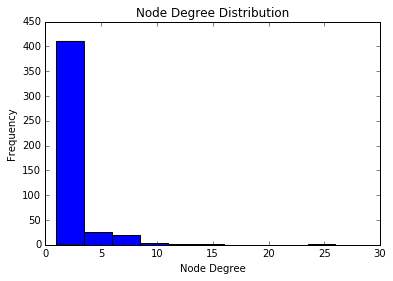

In [14]:
# Plot ground truth ratings on histogram
plt.hist(list(nx.degree(tagGraph).values()))
plt.title("Node Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
fig = plt.gcf()

b.) Node degree skews heavily to the right (i.e. Only a few accounts are mentioned by many people)

In [15]:
def countEdgeWeight(graph):
    edgeList = []
    for node1, node2 in graph.edges():
        edgeList.append([node1, node2, tagGraph[node1][node2]['numberMentions']])
    
    weightDf = pd.DataFrame(edgeList)
    weightDf.columns = ["Node 1", "Node 2", "Edge Weight"]
    return weightDf

In [16]:
# Find top 5 edges by weight
edgeWeightList = countEdgeWeight(tagGraph)
edgeWeightList.sort_values('Edge Weight',ascending=0).head(5)

,Node 1,Node 2,Edge Weight
227,love_slovenia,tweetmeme,4
256,flyersview,airportsleeper,4
245,lakerattravel,rockcampbell,3
79,hashtravel,hyperren,3
1,,immadiva,3


In [17]:
# Determine node position for visualization
getNodePos(tagGraph)

In [18]:
# find max and min edge weights in the graph
maxEdgeWeight = edgeWeightList.sort_values('Edge Weight',ascending=0).head(5).as_matrix()[0][2]
minEdgeWeight = edgeWeightList.sort_values('Edge Weight',ascending=1).head(5).as_matrix()[0][2]

In [19]:
# Plot network where line color indicates edge weight
plotNetwork(tagGraph, minEdgeWeight, maxEdgeWeight)

## Q3.) Content Analysis

In [20]:
def getUserTopKWords(df, userList, k=3):
    userWords = {}
    for user in userList:
        topkWords = countWords(df.loc[df['user']==user]['tweet'].as_matrix()).most_common(k)
        tweetCount = len(df.loc[df['user']==user]['tweet'])
        
        words = {}
        for word, count in topkWords:
            words[word] = count
            
        userWords[user] = {'tweetCount':tweetCount, 'words':words}
        
    return userWords

In [21]:
# Top words that appear across all tweets for the selected hash-tag
pd.DataFrame(countWords(tagDf['tweet'].as_matrix()).most_common(10), columns=["Word", "Count"])

,Word,Count
0,twitter,152
1,added,145
2,directory,144
3,travel,115
4,new,74
5,check,68
6,airgorilla,58
7,(travelto),45
8,save,45
9,hotel,45


Main themes of the tweets include talking about travel related deals, and expressing excitement over new places to visit.

In [22]:
# Plot network with top words (k=3), where size is number of tweets
plotNetwork(tagGraph,minEdgeWeight, maxEdgeWeight, getUserTopKWords(tagDf,tagGraph.nodes()))

## Q4.) Centrality Analysis

In [23]:
# Plot network where size is number of tweets, and color is the betweenness centrality value
plotNetwork(tagGraph, minEdgeWeight, maxEdgeWeight, getUserTopKWords(tagDf,tagGraph.nodes()), nx.betweenness_centrality(tagGraph))

Key users include: @spotcoolstuff (0.094), @velvetescape (0.084), @whereivebeen (0.076), and @goplanit (0.059)

In [44]:
# Plot network where size is number of tweets, and color is the degree centrality value
plotNetwork(tagGraph, minEdgeWeight, maxEdgeWeight, getUserTopKWords(tagDf,tagGraph.nodes()), nx.degree_centrality(tagGraph))

Key users include: @whereivebeen (0.056), @velvetescape (0.030), @spotcoolstuff (0.028), and @hashtravel (0.022)

In [25]:
# Plot network where size is number of tweets, and color is the closeness centrality value
plotNetwork(tagGraph, minEdgeWeight, maxEdgeWeight, getUserTopKWords(tagDf,tagGraph.nodes()), nx.closeness_centrality(tagGraph))

Key users include: @spotcoolstuff (0.141), @velvetescape (0.136), @whereivebeen (0.125), and @goplanit (0.124)

In [46]:
# Plot network where size is number of tweets, and color is the closeness centrality value
plotNetwork(tagGraph, minEdgeWeight, maxEdgeWeight, getUserTopKWords(tagDf,tagGraph.nodes()), usePageRank = True)

Key users include: @whereivebeen (0.0200), @velvetescape (0.0100), @spotcoolstuff (0.0098), and @staybankdotcom (0.0088)

1.) Overall, the different centrality measures identified the same group of users as the most central nodes (albit in different orders).  This is because in this network, there are not many strongly connected components, so the nodes with high degree also act as a common bridge for many nodes.  This is likey due to the more popular tweets expressing travel deals or advetrising highlights for future trips, as most people won't retweet trip details about someone they are not friends with.

2.) Of the tested methods, the betweeness measure was the most useful.  The closeness measure was difficult to identify the major players with as many nodes had similar centality values.  The degree centrality was also useful, but given the tweeting patterns, there are more smaller cliques of users, which are connected by the major users.  Page rank did not provide any new information as other methods tested.

## Q5.) Connectivity Patterns

In [26]:
# 1.) Number of maximal cliques in the graph
print("Number of Maximal cliques: {0}".format(len([clique for clique in nx.find_cliques(tagGraph)])))

Number of Maximal cliques: 394


In [27]:
# 2.) The graph's clique number (size of the largest clique in the graph)
print("Graph's clique number: {0}".format(nx.graph_clique_number(tagGraph)))

Graph's clique number: 3


In [28]:
# 3.) Maximal cliques for each node
pd.DataFrame(list(nx.number_of_cliques(tagGraph).items()), 
             columns=['user', 'Maximal clique']).sort_values('Maximal clique',ascending=0)

,user,Maximal clique
275,whereivebeen,24
327,velvetescape,13
67,spotcoolstuff,12
8,immadiva,11
66,travelinggreen,10
324,natalanihawaii,10
36,hashtravel,9
188,weeklygripe,8
45,staybankdotcom,8
280,lindseygirl,8


In [29]:
# 4.) Size of the largest maximal clique containing each given node
pd.DataFrame(list(nx.node_clique_number(tagGraph).items()), 
             columns=['user', 'Maximal clique']).sort_values('Maximal clique',ascending=0)

,user,Maximal clique
194,video_travel,3
156,aroadretraveled,3
362,runwaygirl,3
297,fisher_david,3
296,travelogged,3
36,hashtravel,3
37,brillianttips,3
114,tweetmeme,3
323,janlawrence,3
275,whereivebeen,3


Based on the above values, this indicates that this network has a lot of cliques, but they are all fairly small.  Combined with the centrality measures in Q4, and reviewing the tweet content, this suggests that majortiy of users are small groups of friends or travel bloggers, and the major users are those that advertise travel deals.

In [38]:
testGraph = nx.pagerank(tagGraph)
print(testGraph[max(testGraph, key=testGraph.get)])
print(max(testGraph.values()))

0.020003386441613428
0.020003386441613428
